In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

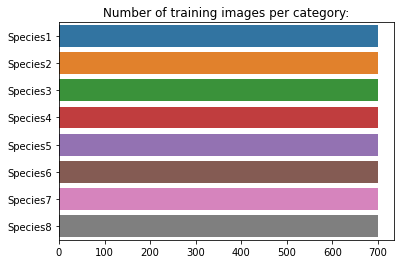

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [9]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [10]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


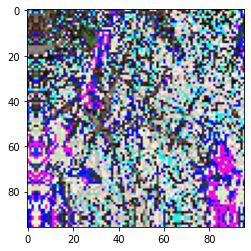

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

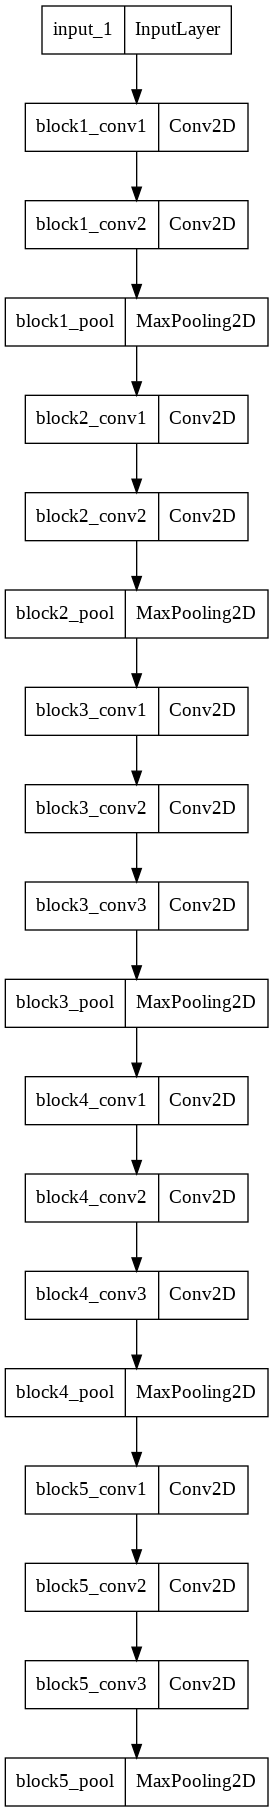

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [14]:
input_shape = (96, 96, 3)
epochs = 200

In [15]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [16]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [17]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 2.8922 - accuracy: 0.4225 - precision: 0.4837 - recall: 0.3177 

175/175 [==============================] - 3196s 18s/step - loss: 2.8922 - accuracy: 0.4225 - precision: 0.4837 - recall: 0.3177 - val_loss: 1.2553 - val_accuracy: 0.5446 - val_precision: 0.7174 - val_recall: 0.3131
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.2903 - accuracy: 0.5461 - precision: 0.6683 - recall: 0.4123

175/175 [==============================] - 30s 172ms/step - loss: 1.2903 - accuracy: 0.5461 - precision: 0.6683 - recall: 0.4123 - val_loss: 1.1171 - val_accuracy: 0.5901 - val_precision: 0.7492 - val_recall: 0.4250
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.1406 - accuracy: 0.5905 - precision: 0.7006 - recall: 0.4630

175/175 [==============================] - 29s 167ms/step - loss: 1.1406 - accuracy: 0.5905 - precision: 0.7006 - recall: 0.4630 - val_loss: 1.0577 - val_accuracy: 0.6243 - val_precision: 0.7582 - val_recall: 0.4402
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.6234 - precision: 0.7331 - recall: 0.5080

175/175 [==============================] - 30s 169ms/step - loss: 1.0543 - accuracy: 0.6234 - precision: 0.7331 - recall: 0.5080 - val_loss: 1.0733 - val_accuracy: 0.6034 - val_precision: 0.7054 - val_recall: 0.4725
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.6479 - precision: 0.7581 - recall: 0.5434

175/175 [==============================] - 30s 169ms/step - loss: 0.9811 - accuracy: 0.6479 - precision: 0.7581 - recall: 0.5434 - val_loss: 1.0470 - val_accuracy: 0.6034 - val_precision: 0.7507 - val_recall: 0.4801
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.6625 - precision: 0.7631 - recall: 0.5700

175/175 [==============================] - 30s 170ms/step - loss: 0.9291 - accuracy: 0.6625 - precision: 0.7631 - recall: 0.5700 - val_loss: 0.9852 - val_accuracy: 0.6300 - val_precision: 0.7251 - val_recall: 0.5104
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.6854 - precision: 0.7737 - recall: 0.5909

175/175 [==============================] - 29s 166ms/step - loss: 0.8690 - accuracy: 0.6854 - precision: 0.7737 - recall: 0.5909 - val_loss: 0.9871 - val_accuracy: 0.6357 - val_precision: 0.7673 - val_recall: 0.5256
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.8512 - accuracy: 0.6911 - precision: 0.7819 - recall: 0.6023

175/175 [==============================] - 30s 170ms/step - loss: 0.8512 - accuracy: 0.6911 - precision: 0.7819 - recall: 0.6023 - val_loss: 0.9831 - val_accuracy: 0.6471 - val_precision: 0.7555 - val_recall: 0.5218
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.6980 - precision: 0.7809 - recall: 0.6111

175/175 [==============================] - 30s 169ms/step - loss: 0.8270 - accuracy: 0.6980 - precision: 0.7809 - recall: 0.6111 - val_loss: 0.9962 - val_accuracy: 0.6262 - val_precision: 0.7209 - val_recall: 0.5047
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.7116 - precision: 0.7967 - recall: 0.6293

175/175 [==============================] - 29s 166ms/step - loss: 0.8004 - accuracy: 0.7116 - precision: 0.7967 - recall: 0.6293 - val_loss: 0.9485 - val_accuracy: 0.6584 - val_precision: 0.7759 - val_recall: 0.5256
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.7223 - precision: 0.7986 - recall: 0.6359

175/175 [==============================] - 29s 168ms/step - loss: 0.7687 - accuracy: 0.7223 - precision: 0.7986 - recall: 0.6359 - val_loss: 0.9351 - val_accuracy: 0.6679 - val_precision: 0.7494 - val_recall: 0.5731
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.7275 - precision: 0.8000 - recall: 0.6457

175/175 [==============================] - 29s 167ms/step - loss: 0.7613 - accuracy: 0.7275 - precision: 0.8000 - recall: 0.6457 - val_loss: 0.9536 - val_accuracy: 0.6528 - val_precision: 0.7578 - val_recall: 0.5522
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.7359 - precision: 0.8043 - recall: 0.6561

175/175 [==============================] - 30s 169ms/step - loss: 0.7481 - accuracy: 0.7359 - precision: 0.8043 - recall: 0.6561 - val_loss: 0.9342 - val_accuracy: 0.6755 - val_precision: 0.7876 - val_recall: 0.5560
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7441 - precision: 0.8162 - recall: 0.6695

175/175 [==============================] - 29s 165ms/step - loss: 0.7291 - accuracy: 0.7441 - precision: 0.8162 - recall: 0.6695 - val_loss: 0.9234 - val_accuracy: 0.6565 - val_precision: 0.7525 - val_recall: 0.5712
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7480 - precision: 0.8143 - recall: 0.6787

175/175 [==============================] - 30s 169ms/step - loss: 0.7197 - accuracy: 0.7480 - precision: 0.8143 - recall: 0.6787 - val_loss: 0.9599 - val_accuracy: 0.6698 - val_precision: 0.7625 - val_recall: 0.5787
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7541 - precision: 0.8208 - recall: 0.6848

175/175 [==============================] - 29s 166ms/step - loss: 0.6916 - accuracy: 0.7541 - precision: 0.8208 - recall: 0.6848 - val_loss: 0.9711 - val_accuracy: 0.6433 - val_precision: 0.7686 - val_recall: 0.5484
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.7445 - precision: 0.8181 - recall: 0.6771

175/175 [==============================] - 29s 166ms/step - loss: 0.7015 - accuracy: 0.7445 - precision: 0.8181 - recall: 0.6771 - val_loss: 0.9612 - val_accuracy: 0.6584 - val_precision: 0.7571 - val_recall: 0.5560
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.7645 - precision: 0.8317 - recall: 0.6961

175/175 [==============================] - 29s 164ms/step - loss: 0.6684 - accuracy: 0.7645 - precision: 0.8317 - recall: 0.6961 - val_loss: 0.9574 - val_accuracy: 0.6793 - val_precision: 0.7733 - val_recall: 0.5825
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7555 - precision: 0.8211 - recall: 0.6907

175/175 [==============================] - 29s 166ms/step - loss: 0.6661 - accuracy: 0.7555 - precision: 0.8211 - recall: 0.6907 - val_loss: 0.9979 - val_accuracy: 0.6641 - val_precision: 0.7551 - val_recall: 0.5674
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7598 - precision: 0.8278 - recall: 0.6946

175/175 [==============================] - 28s 162ms/step - loss: 0.6635 - accuracy: 0.7598 - precision: 0.8278 - recall: 0.6946 - val_loss: 0.9628 - val_accuracy: 0.6528 - val_precision: 0.7408 - val_recall: 0.5750
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7655 - precision: 0.8296 - recall: 0.7032

175/175 [==============================] - 29s 165ms/step - loss: 0.6553 - accuracy: 0.7655 - precision: 0.8296 - recall: 0.7032 - val_loss: 0.9744 - val_accuracy: 0.6698 - val_precision: 0.7627 - val_recall: 0.5427
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.7705 - precision: 0.8312 - recall: 0.7025

175/175 [==============================] - 29s 163ms/step - loss: 0.6653 - accuracy: 0.7705 - precision: 0.8312 - recall: 0.7025 - val_loss: 0.9415 - val_accuracy: 0.6584 - val_precision: 0.7390 - val_recall: 0.5750
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7795 - precision: 0.8448 - recall: 0.7200

175/175 [==============================] - 29s 167ms/step - loss: 0.6384 - accuracy: 0.7795 - precision: 0.8448 - recall: 0.7200 - val_loss: 1.0287 - val_accuracy: 0.6471 - val_precision: 0.7309 - val_recall: 0.5617
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7782 - precision: 0.8335 - recall: 0.7163

175/175 [==============================] - 28s 162ms/step - loss: 0.6491 - accuracy: 0.7782 - precision: 0.8335 - recall: 0.7163 - val_loss: 0.9226 - val_accuracy: 0.6622 - val_precision: 0.7518 - val_recall: 0.5920
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.7859 - precision: 0.8442 - recall: 0.7245

175/175 [==============================] - 29s 166ms/step - loss: 0.6067 - accuracy: 0.7859 - precision: 0.8442 - recall: 0.7245 - val_loss: 1.0177 - val_accuracy: 0.6452 - val_precision: 0.7184 - val_recall: 0.5712
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.7821 - precision: 0.8386 - recall: 0.7230

175/175 [==============================] - 29s 164ms/step - loss: 0.6283 - accuracy: 0.7821 - precision: 0.8386 - recall: 0.7230 - val_loss: 1.0139 - val_accuracy: 0.6660 - val_precision: 0.7438 - val_recall: 0.5731
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7791 - precision: 0.8435 - recall: 0.7179

175/175 [==============================] - 29s 165ms/step - loss: 0.6185 - accuracy: 0.7791 - precision: 0.8435 - recall: 0.7179 - val_loss: 1.0091 - val_accuracy: 0.6509 - val_precision: 0.7201 - val_recall: 0.5712
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7839 - precision: 0.8446 - recall: 0.7271

175/175 [==============================] - 28s 163ms/step - loss: 0.6185 - accuracy: 0.7839 - precision: 0.8446 - recall: 0.7271 - val_loss: 0.9739 - val_accuracy: 0.6812 - val_precision: 0.7685 - val_recall: 0.5920
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.7896 - precision: 0.8407 - recall: 0.7387

175/175 [==============================] - 29s 165ms/step - loss: 0.6009 - accuracy: 0.7896 - precision: 0.8407 - recall: 0.7387 - val_loss: 0.9962 - val_accuracy: 0.6755 - val_precision: 0.7537 - val_recall: 0.5750
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.7886 - precision: 0.8443 - recall: 0.7341

175/175 [==============================] - 28s 162ms/step - loss: 0.6093 - accuracy: 0.7886 - precision: 0.8443 - recall: 0.7341 - val_loss: 1.0353 - val_accuracy: 0.6850 - val_precision: 0.7476 - val_recall: 0.5844
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.7986 - precision: 0.8515 - recall: 0.7496

175/175 [==============================] - 29s 165ms/step - loss: 0.5789 - accuracy: 0.7986 - precision: 0.8515 - recall: 0.7496 - val_loss: 0.9978 - val_accuracy: 0.6698 - val_precision: 0.7518 - val_recall: 0.5920
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7941 - precision: 0.8413 - recall: 0.7443

175/175 [==============================] - 29s 163ms/step - loss: 0.6053 - accuracy: 0.7941 - precision: 0.8413 - recall: 0.7443 - val_loss: 1.0505 - val_accuracy: 0.6641 - val_precision: 0.7295 - val_recall: 0.5731
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.7959 - precision: 0.8534 - recall: 0.7466

175/175 [==============================] - 29s 167ms/step - loss: 0.5898 - accuracy: 0.7959 - precision: 0.8534 - recall: 0.7466 - val_loss: 0.9900 - val_accuracy: 0.6679 - val_precision: 0.7488 - val_recall: 0.5939
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.7971 - precision: 0.8578 - recall: 0.7446

175/175 [==============================] - 28s 163ms/step - loss: 0.5801 - accuracy: 0.7971 - precision: 0.8578 - recall: 0.7446 - val_loss: 0.9862 - val_accuracy: 0.6546 - val_precision: 0.7518 - val_recall: 0.5863
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7961 - precision: 0.8527 - recall: 0.7461

175/175 [==============================] - 29s 164ms/step - loss: 0.5868 - accuracy: 0.7961 - precision: 0.8527 - recall: 0.7461 - val_loss: 1.0715 - val_accuracy: 0.6603 - val_precision: 0.7136 - val_recall: 0.5863
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.8066 - precision: 0.8565 - recall: 0.7600

175/175 [==============================] - 28s 162ms/step - loss: 0.5509 - accuracy: 0.8066 - precision: 0.8565 - recall: 0.7600 - val_loss: 1.0272 - val_accuracy: 0.6414 - val_precision: 0.7257 - val_recall: 0.5674
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.8054 - precision: 0.8530 - recall: 0.7532

175/175 [==============================] - 29s 164ms/step - loss: 0.5749 - accuracy: 0.8054 - precision: 0.8530 - recall: 0.7532 - val_loss: 1.0060 - val_accuracy: 0.6660 - val_precision: 0.7447 - val_recall: 0.6034
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7987 - precision: 0.8517 - recall: 0.7484

175/175 [==============================] - 28s 162ms/step - loss: 0.5720 - accuracy: 0.7987 - precision: 0.8517 - recall: 0.7484 - val_loss: 0.9577 - val_accuracy: 0.6850 - val_precision: 0.7600 - val_recall: 0.6129
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.8004 - precision: 0.8534 - recall: 0.7493

175/175 [==============================] - 29s 164ms/step - loss: 0.5671 - accuracy: 0.8004 - precision: 0.8534 - recall: 0.7493 - val_loss: 1.0462 - val_accuracy: 0.6717 - val_precision: 0.7387 - val_recall: 0.5901
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.8021 - precision: 0.8497 - recall: 0.7520

175/175 [==============================] - 28s 162ms/step - loss: 0.5468 - accuracy: 0.8021 - precision: 0.8497 - recall: 0.7520 - val_loss: 1.0999 - val_accuracy: 0.6528 - val_precision: 0.7227 - val_recall: 0.5787


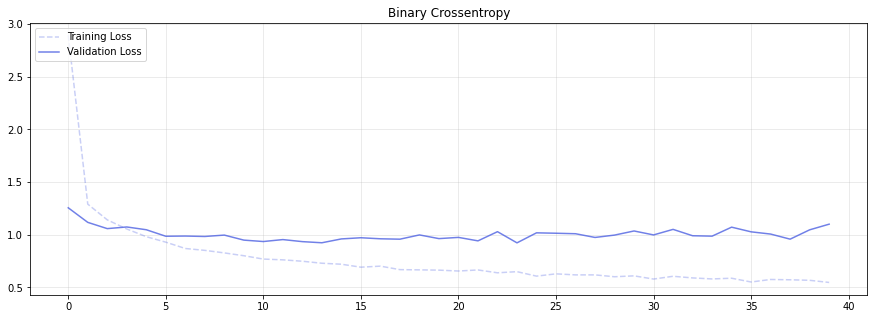

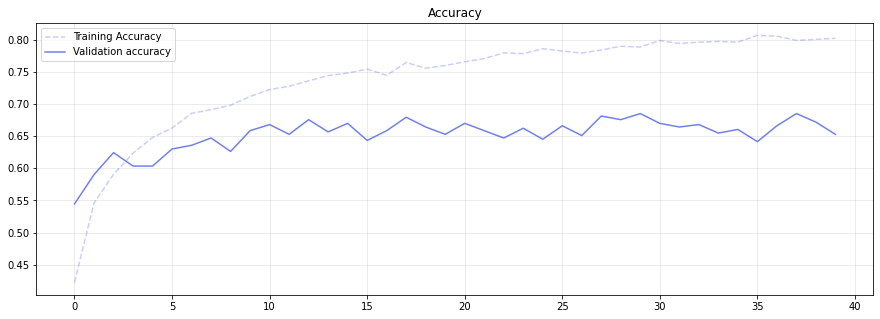

In [18]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [19]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [20]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [21]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [22]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [23]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [24]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 27s 138ms/step - loss: 0.9829 - accuracy: 0.6796 - precision_1: 0.7615 - recall_1: 0.5986 - val_loss: 0.9451 - val_accuracy: 0.6679 - val_precision_1: 0.7586 - val_recall_1: 0.5844
Epoch 2/200
175/175 [==============================] - 23s 133ms/step - loss: 0.7885 - accuracy: 0.7441 - precision_1: 0.8103 - recall_1: 0.6741 - val_loss: 0.9037 - val_accuracy: 0.6907 - val_precision_1: 0.7806 - val_recall_1: 0.5806
Epoch 3/200
175/175 [==============================] - 23s 134ms/step - loss: 0.6320 - accuracy: 0.7837 - precision_1: 0.8413 - recall_1: 0.7232 - val_loss: 0.9752 - val_accuracy: 0.7078 - val_precision_1: 0.7635 - val_recall_1: 0.6186
Epoch 4/200
175/175 [==============================] - 24s 135ms/step - loss: 0.5682 - accuracy: 0.8155 - precision_1: 0.8659 - recall_1: 0.7566 - val_loss: 0.8571 - val_accuracy: 0.7116 - val_precision_1: 0.7925 - val_recall_1: 0.6452
Epoch 5/200
175/175 [==============================] - 2

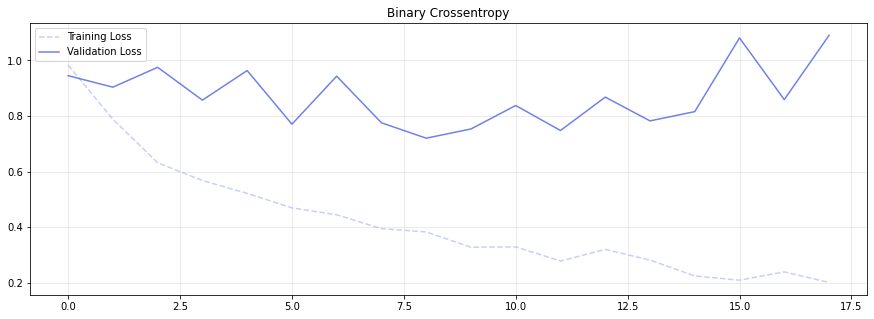

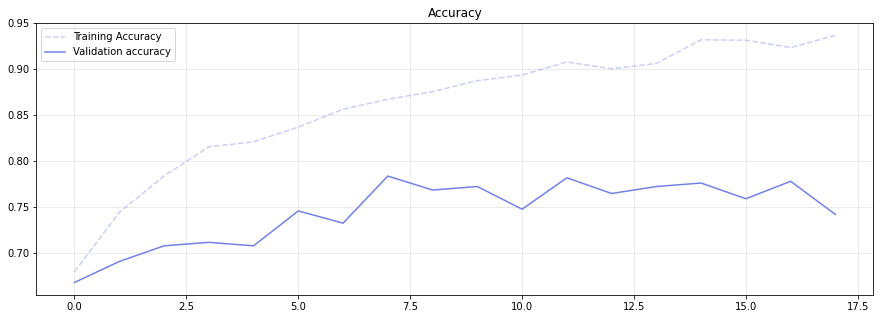

In [25]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [26]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [27]:
tl_model.save('Vgg16/Tuned_v1_1')

In [28]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 192s 17s/step - loss: 0.8372 - accuracy: 0.7784 - precision_1: 0.8024 - recall_1: 0.7535

Test metrics
{'loss': 0.8371734023094177, 'accuracy': 0.7783933281898499, 'precision_1': 0.8023598790168762, 'recall_1': 0.7534626126289368}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7784
Precision: 0.7656
Recall: 0.7635
F1: 0.762


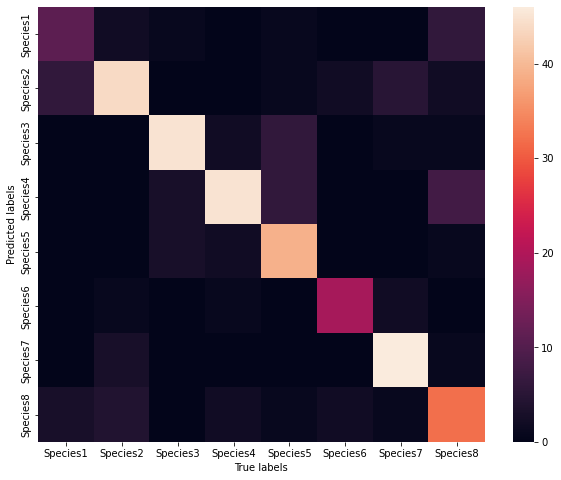

In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()